In [1]:
import requests as req
import pandas as pd
import os
import json
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
sns.set_theme(style="darkgrid")
import datetime
from statsmodels.tools import add_constant
from sklearn.linear_model import LinearRegression 
%matplotlib inline

KEY = ''
TIMESCALE = '1y'
DATA_FILE = 'data'
ETF_DATA_FILE = 'etfdata'

In [2]:
def get_SP():
    table = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    df = table[0]
    df.to_csv('S&P500-Info.csv')
    df.to_csv("S&P500-Symbols.csv", columns=['Symbol'])
    return df

In [3]:
symb = get_SP()[::]['Symbol']
TICKERS = [symb[i] for i in range(len(symb))]
ETF_TICKERS = ['XLC', 'XLY', 'XLP', 'XLE', 'XLF', 'XLV', 'XLI', 'XLB', 'XLRE', 'XLK', 'XLU']
def fetch_data(tickers, timescale, key, dataloc=DATA_FILE):
    for ticker in tickers: 
        url = f'https://cloud.iexapis.com/v1/stock/{ticker}/chart/{timescale}?token={key}'
        res = req.get(url)
        with open(f'{dataloc}/{ticker}{timescale}.json', 'w') as f:
            json.dump(res.json(), f)
            f.close()

#fetch_data(etf_tickers, TIMESCALE, KEY, ETF_DATA_FILE)

In [4]:
def get_sector_etf(sector):
    categories = ['Communication Services', 'Consumer Discretionary', 'Consumer Staples', 'Energy', 'Financials', 'Health Care', 'Industrials', 'Materials', 'Real Estate', 'Information Technology', 'Utilities']
    return ETF_TICKERS[categories.index(sector)]



def get_returns_data(dataloc=DATA_FILE):
    folder = os.listdir(dataloc)
    N = len(folder)
    # SP500 Data Frame datascrape 
    SP = get_SP()
    # map the ticker name to index in the dataframe
    ticker_to_index = {v:k for k,v in SP['Symbol'].to_dict().items()}
    # map returns index to ticker name and sector 
    ticker_map = {}
    returns = []
    dates = []
    offset = 0 
    for n, filename in enumerate(folder):
        # ignore hidden mac files
        if filename == '.DS_Store' or filename.startswith('.'):
            offset += 1
            continue
            
        with open(f'{dataloc}/{filename}', 'r') as file:
            data = json.load(file)
            file.close()
    
        # only use adjusted close data
        ticker = filename.split('1y.json')[0]
        # exclude the first day in returns data
        ticker_return = [days['changePercent']*100 for days in data][1:]
        # map index -> ticker string, ticker etf
        # map ticker string -> index
        if ticker not in ETF_TICKERS:
            ticker_map[n-offset] = (ticker, get_sector_etf(SP['GICS Sector'][ticker_to_index[ticker]]))
            ticker_map[ticker] = n-offset
        else:
            ticker_map[n-offset] = ticker
            ticker_map[ticker] = n-offset
            
            
        dates.append([days['date'] for days in data])

        returns.append(ticker_return)
        
    return_mat = np.zeros((len(returns), len(returns[0])))

    for i in range(len(returns)):
        for j in range(len(returns[i])):
            return_mat[i,j] = returns[i][j]
    
    return return_mat, ticker_map, dates
    

def get_volume_data(dataloc=DATA_FILE):
    volume = []
    folder = os.listdir(dataloc)
    N = len(folder)
    offset = 0
    for n, filename in enumerate(folder):
        # ignore hidden mac files
        if filename == '.DS_Store' or filename.startswith('.'):
            offset += 1
            continue
            
        with open(f'{dataloc}/{filename}', 'r') as file:
            data = json.load(file)
            file.close()
            
        ticker_volume = [days['volume'] for days in data]
        
        volume.append(ticker_volume)
        
    
    return volume

    






In [5]:
# display "coherence" of a PCA eigenvector
# sort eigenvector coefficients and plot against industry of stock 
def graph_coherence(eigenvector, num, xlabels=True):
    # get the sector etf corresponding to the stock 
    x = [(val, ticker_map[i][1]) for i, val in enumerate(eigenvector.T * -1)] 
    # truncate to the first num stocks to graph
    xx = [i[1] for i in x[:num]]
    # coefficients 
    xy = sorted([np.real(i[0][0,0]) for i in x[:num]], reverse=True)
    plt.plot(xy)
    if xlabels:
        plt.xticks(range(num), xx , rotation='vertical')
        plt.xlabel('Industry Sector')
    plt.title('Coherence of Eigenvector')
    plt.ylabel('Coefficient')
    plt.show()
    
def graph_returns(arr, ticker, num):
    plt.figure(num)
    plt.xlabel('Days since 8/03/2020')
    plt.ylabel('Logarithmic Return')
    plt.plot(np.cumsum(arr), label=ticker)
    plt.legend()


In [6]:
def PCA_factors(returns, start_t, end_t, factors):
    snap = returns.T[start_t:end_t]
    period = len(snap)
    N = len(returns)
    returns = np.transpose(snap)
    Std = np.zeros(N)
    Y = np.zeros((N, period))
    for i in range(N): 
        R_bar = np.mean(returns[i])
        sigma = np.std(returns[i])
        Std[i] = sigma
        Y[i] = (returns[i] - R_bar)/sigma
        
    # pearson correlation matrix with dimensions N x N
    P = np.matmul(Y, Y.T) * (1 / (period))
    eigval, eigvec = np.linalg.eig(P)
    # eigvectors are columnwise
    eigvec = eigvec.T

    # sort eigenvectors based on eigenvalue size, largest to smallest
    # truncate to preserve #factors principal components
    e = sorted([(eigval[i], i) for i in range((len(eigval)))], reverse=True)
    eigvec = np.mat([eigvec[index[1]] for index in e])[:factors]    

    # eigenportfolios
    # long/short pairs on the level of sectors
    # first eigenportfolio is market portfolio, rest are orthogonal 
    Q = np.zeros((factors, N))
    for p in range(factors):
        for i in range(N):
            Q[p, i] = np.real(np.divide(eigvec[p, i], Std[i]))
            
    # p x T
    # Market factors returns 
    F = np.inner(Q, returns.T)
        
    # Market factor coefficients (betas)
    # Multivariate least squares of R on F 
    model = LinearRegression()
    model.fit(F.T, returns.T)
    
    # N x p 
    # factor loadings
    L = model.coef_
    
    # Calculate residuals according to R = LF + U     
    U = returns - np.matmul(L, F)
    
    return L, U

def ETF_factors(returns, etf_returns, period):
    N = len(returns)
    L = np.zeros((N, 1))
    U = np.zeros((N, period))
    for stock in range(N):
        etf = ticker_map[stock][1]
        index = etf_map[etf]     
        sector_returns = etf_returns[index]
        # use etf returns as market factors  
        model = LinearRegression().fit(sector_returns.reshape(period, 1), returns[stock].reshape(period, 1))
        # factor loadings are the slope of regression
        L[stock] = model.coef_ 
        # calculate residuals 
        U[stock] = returns[stock] - np.matmul(L[stock], sector_returns.reshape(1, period))
    
    return L, U
    
 
def OU_estimation(L, U):
    stock_score = []  
    stock_kappa = [] 
    
    for i in range(len(U)):
        X = np.cumsum(U[i])
        t = len(X) - 1
        Xt = X[0:-1].reshape(t,1)
        Xt1 = X[1:].reshape(t,1)
        ls = LinearRegression(fit_intercept=True).fit(Xt, Xt1)
        beta = ls.coef_[0][0]
        if beta > 1 :
            beta = .9672 
        alpha = ls.intercept_[0]
        # epsilon -> random process of t+1 residual  
        epsilon = Xt1 - alpha - beta * Xt
        k = -np.log10(beta) * 252
        m = alpha / (1 - beta)
        sigma = np.sqrt((np.var(epsilon))/(1-np.power(beta, 2)))
        score = (X[t]-m) / sigma 
        # print(f'score {score}, {i}')
        # adjust score for drift 
        modscore = (score - (alpha/(k*sigma)))
        stock_kappa.append(k)
        stock_score.append(modscore)
        
        
    return stock_kappa, stock_score 

In [7]:
returns, ticker_map, dates = get_returns_data(DATA_FILE)
etf_returns, etf_map, _ = get_returns_data(ETF_DATA_FILE) 
stock_volume = get_volume_data(DATA_FILE)
etf_volume = get_volume_data(ETF_DATA_FILE)

In [8]:
def vol_weighted_returns(volume_arr, returns, start_t, end_t):
    period = end_t - start_t
    weighted_returns = np.zeros((len(returns), period))
    # for all assets in the returns array
    for i in range(len(returns)):
        # calculate the 60 day simple moving average for the volume of the stock/etf
        mvavg_vol = sum(volume_arr[i][start_t:end_t])/(period)
        for t in range(period):
            weighted_returns[i][t] = returns[i][t] * (mvavg_vol / volume_arr[i][t])
            
            

    return weighted_returns

Day 60 returns: 0


Day 61 returns: 2419.9748868550146


Day 62 returns: 442.2375896152233


Day 63 returns: 1157.9218199181946


Day 64 returns: 879.3980549211703


Day 65 returns: 2682.1498600921545


Day 66 returns: 1124.4925891157654


Day 67 returns: -308.2655891268059


Day 68 returns: 64.40671187812205


Day 69 returns: 726.2335990969578


Day 70 returns: 1634.1349641118272


Day 71 returns: -858.4555312403688


Day 72 returns: 1262.4222491358519


Day 73 returns: 423.44307500042544


Day 74 returns: 73.3964061218728


Day 75 returns: 8.545120571232232


Day 76 returns: 659.2279363759918


Day 77 returns: -673.6620853205931


Day 78 returns: 1970.4701648054984


Day 79 returns: 1540.827584364435


Day 80 returns: -275.8648043702315


Day 81 returns: 1579.9275209374819


Day 82 returns: -389.03312059655235


Day 83 returns: 1143.6963614887688


Day 84 returns: -1264.1234691530397


Day 85 returns: -433.9119988176584


Day 86 returns: 1589.143636260527


Day 87 returns: 666.993943

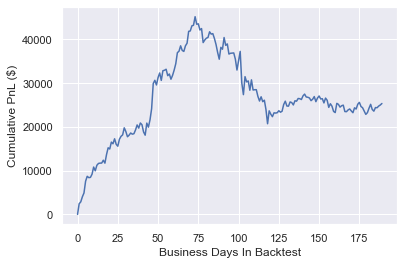

In [9]:
# Backtesting program
first = 60
last = 250
cash = 300000
estimation_window = 60
total_return = []
portfolio_breakdown = []
portfolio = {}
positions = {n:0 for n in range(len(returns))}
ticker_stats = {ticker_map[n][0]:0 for n in range(len(returns))}
etf_stats = {etf_map[n]:0 for n in range(len(etf_returns))}
kval = []
signal_evo = [] 
for day in range(first, last):
    end = day
    start = day - estimation_window
    period = end - start
    # get returns matrix of just start:end 
    snap_returns = np.transpose(returns.T[start:end])
    snap_etf_returns = np.transpose(etf_returns.T[start:end])
    # calculate market factors and residuals
    L, U = ETF_factors(snap_returns, snap_etf_returns, period)
    kappa, signal = OU_estimation(L, U)
    # filter out stocks based on mean reversion factor
    # estimated mean reversion must occur within ~8 days
    filtered = [i for i,x in enumerate(kappa) if (x < (252/(estimation_window * 0.5)))]
    
    
    # generate returns from portfolio at the start of the trading day
    returns_mat = returns.T[day]
    etf_returns_mat = etf_returns.T[day]
    day_returns = 0

    for ticker in portfolio.keys():
        if ticker in ETF_TICKERS:
            index = etf_map[ticker]
            etf_return = portfolio[ticker] * (etf_returns_mat[index]/100)
            # print(f'{ticker} return: {etf_return}, {etf_returns_mat[index]/100}')
            day_returns += etf_return
            etf_stats[ticker] += etf_return
        else:
            index = ticker_map[ticker]
            stock_return = portfolio[ticker] * (returns_mat[index]/100)
            # print(f'{ticker} return: {stock_return}, {returns_mat[index]/100}')
            day_returns += stock_return
            ticker_stats[ticker] += stock_return 
            
    print(f'Day {day} returns: {day_returns}')
    print('\n')
    
    # calculate long/short percentages
    total_long = sum([val for val in portfolio.values() if val > 0])
    total_short = sum([val for val in portfolio.values() if val < 0])
    portfolio_breakdown.append((total_long/cash, total_short/cash))
    
    # track returns, kappa values, and signals for graphing
    total_return.append(float(day_returns))
    kval.append(kappa)
    signal_evo.append(signal)
            
    # assign new positions using closing prices
    for n, sig in enumerate(signal):
        take_pos = n in filtered
        # if we already have a position, check for exit condition
        if positions[n] != 0:
            if (positions[n] == 1 and sig > -.5) or (positions[n] == -1 and sig < 1.25):
                positions[n] = 0 
            if not take_pos:
                positions[n] = 0 
                
        # if we don't have a position, check for entry condition
        else:
            if sig < -1.25 and take_pos:
                positions[n] = 1
            
            elif sig > 2 and take_pos:
                positions[n] = -1 
            
            
            else:
                positions[n] = 0 
                
    
    # equal weight every position in the portfolio
    # could modify to an optimization problem
    total_pos = len([pos for pos in positions.values() if pos != 0])
    
    # create new portfolio
    # pair trade stock and associated etf
    portfolio = {} 
    for pos in positions.items():
        index = pos[0]
        stock, etf = ticker_map[index]
        # long stock, short etf
        if pos[1] == 1:
            long = (1 / total_pos) * cash
            short = L[index][0] * long * -1
            portfolio[stock] = long 
            if etf in portfolio.keys():
                portfolio[etf] += short
            else:
                portfolio[etf] = short
                
        # short stock, long etf
        elif pos[1] == -1:
            short = (1 / total_pos) * cash * -1
            long = short * L[index][0] * -1
            portfolio[stock] = short
            if etf in portfolio.keys():
                portfolio[etf] += long
            else:
                portfolio[etf] = long 
                
                
                
                
                
                
print('\n')
plt.figure(1)
# plot the cumulative pnl for the backtest
plt.xlabel('Business Days In Backtest')
plt.ylabel('Cumulative PnL ($)')
sns.lineplot(data=np.cumsum(total_return, dtype=object))
plt.savefig('cumulativepnl')
                        

print('\n')
print(f'Total Return: {np.sum(total_return)}')
percent = (np.sum(total_return)/cash)*100
print('Percentage Return: {:.2f}%'.format(percent))
sharpe = (np.mean(total_return)/np.std(total_return))* (252 ** .5)
print(f'Sharpe Ratio: {sharpe}')

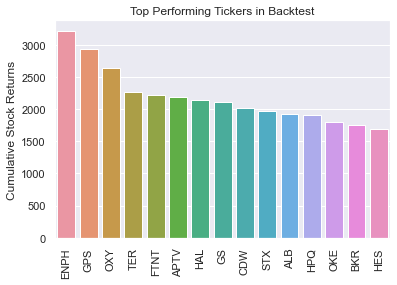

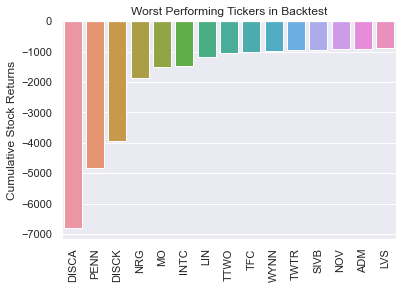

In [10]:
plt.figure(2)
sorted_stats = dict(sorted(ticker_stats.items(), key=lambda item: item[1], reverse=True))
plt.xticks(range(15), list(sorted_stats.keys())[:15], rotation='vertical')
sns.barplot(x=list(sorted_stats.keys())[:15], y=list(sorted_stats.values())[:15])
plt.ylabel('Cumulative Stock Returns')
plt.title('Top Performing Tickers in Backtest')
plt.savefig('topperformers')

plt.figure(3)
sorted_stats = dict(sorted(ticker_stats.items(), key=lambda item: item[1]))
plt.xticks(range(15), list(sorted_stats.keys())[:15], rotation='vertical')
sns.barplot(x=list(sorted_stats.keys())[:15], y=list(sorted_stats.values())[:15])
plt.ylabel('Cumulative Stock Returns')
plt.title('Worst Performing Tickers in Backtest')
plt.savefig('worstperformers')


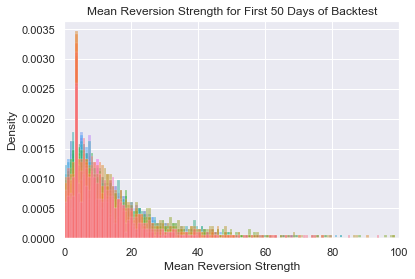

In [11]:
fig, ax = plt.subplots()
sns.histplot(kval[:50], stat='density', ax=ax, alpha=0.5, legend=False)
plt.xlim([0,100])
plt.xlabel('Mean Reversion Strength')
plt.title('Mean Reversion Strength for First 50 Days of Backtest')
plt.savefig('kappadistribution')

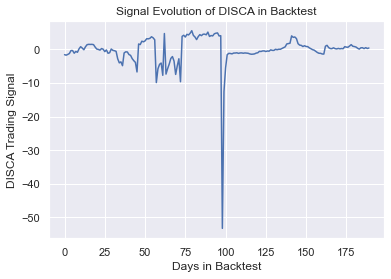

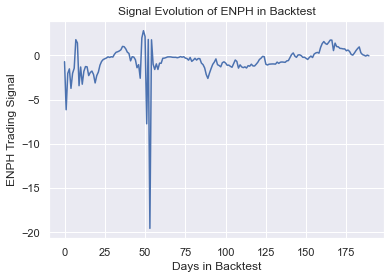

In [12]:
fig, ax = plt.subplots()
signal_evo = pd.DataFrame(signal_evo)
sns.lineplot(data=signal_evo.iloc[:,ticker_map['DISCA']])
plt.xlabel('Days in Backtest')
plt.ylabel('DISCA Trading Signal')
plt.title('Signal Evolution of DISCA in Backtest')
plt.savefig('DISCAsignal')


fig, ax = plt.subplots()
sns.lineplot(data=signal_evo.iloc[:,ticker_map['ENPH']])
plt.xlabel('Days in Backtest')
plt.ylabel('ENPH Trading Signal')
plt.title('Signal Evolution of ENPH in Backtest')
plt.savefig('ENPHsignal')

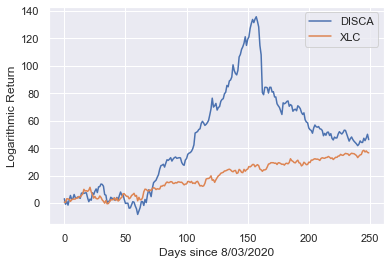

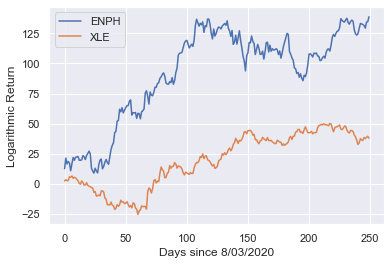

In [13]:
graph_returns(returns[ticker_map['DISCA']], 'DISCA', 1)
graph_returns(etf_returns[etf_map['XLC']], 'XLC', 1)
plt.savefig('DISCAgraph')


graph_returns(returns[ticker_map['ENPH']], 'ENPH', 2)
graph_returns(etf_returns[etf_map['XLE']], 'XLE', 2)
plt.savefig('ENPHgraph')